 <font color='purple'><h1><center>Model Building for [Step Project](https://www.kaggle.com/c/iba-ml2-mid-project)</center></h1>

In [1]:
#importing main libraries;

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#importing preprocessing features;
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PolynomialFeatures

#scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer

#encoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

#imputer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

#importing algortihms
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier


#pipeline
from sklearn.pipeline import Pipeline
from IPython.core.display import HTML
from sklearn.utils import estimator_html_repr

#outlier detection
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor

#metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, make_scorer

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv', index_col='Id') #We don't really need the ID column to be found in the train dataset, therefore I setting it as index

In [3]:
df_test = pd.read_csv('test.csv', index_col='Id') #Same applies to the ID column of test dataset.

In [4]:
import warnings
warnings.filterwarnings('ignore')  #just to ignore warnings related to graphs and other codes.

In [5]:
df['credit_line_utilization'] = df['credit_line_utilization'].str.replace(',' , '.').astype(float) 

In [6]:
df_test['credit_line_utilization'] = df_test['credit_line_utilization'].str.replace(',' , '.').astype(float)

<i> <font size='4'> There were comma(',') instead of dot('.') in the credit_line_utilization column in both test and train datasets, therefore I cleaned these and changed the datatype to float.</font>

### <font size='5'> Outlier Handling

In [7]:
df.isna().sum()

age                                                 7144
number_dependent_family_members                     4216
monthly_income                                      6016
number_of_credit_lines                              6154
real_estate_loans                                   3806
ratio_debt_payment_to_income                        5608
credit_line_utilization                             6346
number_of_previous_late_payments_up_to_59_days      4195
number_of_previous_late_payments_up_to_89_days      5845
number_of_previous_late_payments_90_days_or_more    3621
defaulted_on_loan                                      0
dtype: int64

In [8]:
df.isna().sum().sum()

52951

<i><font size='4'> <font color='red'> To increase model accuracy </font>, I am adding <font color='red'> new column (Debt Payment) </font> which is created with Monthly_Income and Ratio_debt_payment_to_income columns. For exporting output from the test dataset, I have to add this new column to the test dataset as well, otherwise I will get an 'error'. By adding this column I increased my accuracy score.

In [9]:
df_test['Debt Amount'] = df_test['monthly_income'] * df_test['ratio_debt_payment_to_income'] # as stated above, I am inserting
# new column to test dataset as well.

In [10]:
X = df.drop(columns="defaulted_on_loan",axis=1)
y = df["defaulted_on_loan"]

In [11]:
X_train = df.drop(columns="defaulted_on_loan",axis=1)
y_train = df["defaulted_on_loan"]

In [12]:
X['Debt Amount'] = X['monthly_income'] * X['ratio_debt_payment_to_income'] #creating new column called "Debt Amount"

<i><font size='3.5'>For each column, I calculated z-score and changed value of the rows of column to 'NaN' whereas z-score is more than 3 which we can call Outliers. Later, inside of the pipeline, these NaN values will be imputed, which means we are not losing any rows with dropping outlier values.

In [13]:
X['age_z_score'] = (X['age'] - X.age.mean()) / X.age.std()
X['number_dependent_family_members_score'] = (X['number_dependent_family_members'] - X.number_dependent_family_members.mean()) / X.number_dependent_family_members.std()
X['monthly_income_score'] = (X['monthly_income'] - X.monthly_income.mean()) / X.monthly_income.std()
X['number_of_credit_lines_score'] = (X['number_of_credit_lines'] - X.number_of_credit_lines.mean()) / X.number_of_credit_lines.std()
X['real_estate_loans_score'] = (X['real_estate_loans'] - X.real_estate_loans.mean()) / X.real_estate_loans.std()
X['ratio_debt_payment_to_income_score'] = (X['ratio_debt_payment_to_income'] - X.ratio_debt_payment_to_income.mean()) / X.ratio_debt_payment_to_income.std()
X['credit_line_utilization_score'] = (X['credit_line_utilization'] - X.credit_line_utilization.mean()) / X.credit_line_utilization.std()
X['number_of_previous_late_payments_up_to_59_days_score'] = (X['number_of_previous_late_payments_up_to_59_days'] - X.number_of_previous_late_payments_up_to_59_days.mean()) / X.number_of_previous_late_payments_up_to_59_days.std()
X['number_of_previous_late_payments_up_to_89_days_score'] = (X['number_of_previous_late_payments_up_to_89_days'] - X.number_of_previous_late_payments_up_to_89_days.mean()) / X.number_of_previous_late_payments_up_to_89_days.std()
X['number_of_previous_late_payments_90_days_or_more_score'] = (X['number_of_previous_late_payments_90_days_or_more'] - X.number_of_previous_late_payments_90_days_or_more.mean()) / X.number_of_previous_late_payments_90_days_or_more.std()
X['Debt Amount Score'] = (X['Debt Amount'] - X['Debt Amount'].mean()) / X['Debt Amount'].std() 

In [14]:
X.loc[X['age_z_score'] > 3, 'age'] = np.nan
X.loc[X['number_dependent_family_members_score'] > 3, 'number_dependent_family_members'] = np.nan
X.loc[X['monthly_income_score'] > 3, 'monthly_income'] = np.nan
X.loc[X['number_of_credit_lines_score'] > 3, 'number_of_credit_lines'] = np.nan
X.loc[X['real_estate_loans_score'] > 3, 'real_estate_loans'] = np.nan
X.loc[X['ratio_debt_payment_to_income_score'] > 3, 'ratio_debt_payment_to_income'] = np.nan
X.loc[X['credit_line_utilization_score'] > 3, 'credit_line_utilization'] = np.nan
X.loc[X['number_of_previous_late_payments_up_to_59_days_score'] > 3, 'number_of_previous_late_payments_up_to_59_days'] = np.nan
X.loc[X['number_of_previous_late_payments_up_to_89_days_score'] > 3, 'number_of_previous_late_payments_up_to_89_days'] = np.nan
X.loc[X['number_of_previous_late_payments_90_days_or_more_score'] > 3, 'number_of_previous_late_payments_90_days_or_more'] = np.nan
X.loc[X['Debt Amount Score'] > 3, 'Debt Amount'] = np.nan

In [15]:
X = X.drop(columns=['age_z_score', 'number_dependent_family_members_score','monthly_income_score','number_of_credit_lines_score','real_estate_loans_score','ratio_debt_payment_to_income_score','credit_line_utilization_score','number_of_previous_late_payments_up_to_59_days_score','number_of_previous_late_payments_up_to_89_days_score','number_of_previous_late_payments_90_days_or_more_score','Debt Amount Score'])

In [16]:
numeric = X_train.columns.to_list() #(All of our columns are numeric except target column)

In [17]:
categorical = []  

### <font size='5'> Model Fitting

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3,random_state=42)

In [19]:
# Imputer_num = SimpleImputer(strategy='median')
# X_train[numeric] = Imputer_num.fit_transform(X_train[numeric])   #mean is the best

In [20]:
# elliptic= EllipticEnvelope(contamination=0.01)
# pred_outlier = elliptic.fit_predict(X_train)
# mask = pred_outlier != -1

# X_train_eli, y_train_eli = X_train.iloc[mask, :], y_train[mask]
#  # Outliers are detected and filtered out.

In [21]:
# iso = IsolationForest(contamination=0.01)
# outlier_pred = iso.fit_predict(X_train[numeric])
# mask = outlier_pred != -1

# X_train_iso, y_train_iso = X_train.iloc[mask, :], y_train[mask]
#  # Outliers are detected and filtered out.

<i> <font size='4'>I tried 2 types of Outlier detection, but none of them gave better result than the manual outlier removal as implemented above.

## XGBClassifier

In [22]:
categorical_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('one_hot_encoding', OneHotEncoder(handle_unknown = "ignore"))
])

numeric_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

column_transformer=ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric),
    ('categorical', categorical_transformer, categorical)
])

model_xgb=Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('classifier', XGBClassifier(gamma=5, max_depth=3, min_child_weight=5, subsample=1.0, colsample_bytree=0.8))
])                    
model_xgb.fit(X_train, y_train)
print(classification_report(y_test, model_xgb.predict(X_test)))

[11:57:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     20149
           1       0.60      0.15      0.23      1500

    accuracy                           0.93     21649
   macro avg       0.77      0.57      0.60     21649
weighted avg       0.92      0.93      0.91     21649



<i> <font size='4'> I did run GridSearch for hyperparameter tuning of XGBoost Classifier, It took a lot of computing power and time, therefore, I am directly using the best paramteres above and gridsearch part will be commented out.

In [23]:
# param_space = {
#         'classifier__min_child_weight': [1, 5, 10],
#         'classifier__gamma': [0.5, 1, 1.5, 2, 5],
#         'classifier__subsample': [0.6, 0.8, 1.0],
#         'classifier__colsample_bytree': [0.6, 0.8, 1.0],
#         'classifier__max_depth': [3, 4, 5]
# }

In [24]:
# gridsearch=GridSearchCV(model_pipeline1,param_space,cv=StratifiedKFold()) #Utilized StratifiedKFold in gridsearch

This gridsearch is taking a lot of computing power :) took me to run for more than 1 hour.

In [25]:
# gridsearch.fit(X_train, y_train)

In [26]:
# final_model = gridsearch.best_estimator_
# final_model.fit(X_train,y_train)

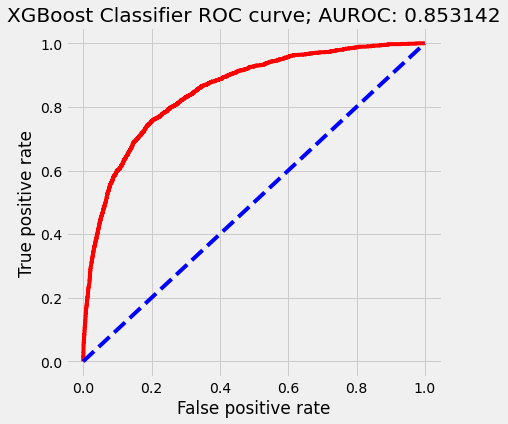

In [27]:
plt.style.use('fivethirtyeight')
prediction = model_xgb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='r')

plt.plot(fpr, fpr, linestyle = 'dashed', color = 'b')

plt.xlabel('False positive rate')

plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_test, prediction), 6)

plt.title(f'XGBoost Classifier ROC curve; AUROC: {AUROC}');

plt.show()

In [28]:
# y_pred=final_model1.predict_proba(test)[:,1]
# pred=pd.DataFrame(y_pred)
# test.reset_index(inplace=True)

In [29]:
# dataset=pd.concat([test['Id'], pred], axis=1)
# dataset.columns=['Id','Predicted']
# dataset.to_csv('XGB5_SKF.csv',index=False)

## RandomForestClassifier

In [30]:
categorical_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('one_hot_encoding', OneHotEncoder(handle_unknown = "ignore"))
])

numeric_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

column_transformer=ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric),
    ('categorical', categorical_transformer, categorical)
])

model_rf=Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('classifier', RandomForestClassifier(max_depth=2, random_state=0))
])                    
model_rf.fit(X_train, y_train)
print(classification_report(y_test, model_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96     20149
           1       0.00      0.00      0.00      1500

    accuracy                           0.93     21649
   macro avg       0.47      0.50      0.48     21649
weighted avg       0.87      0.93      0.90     21649



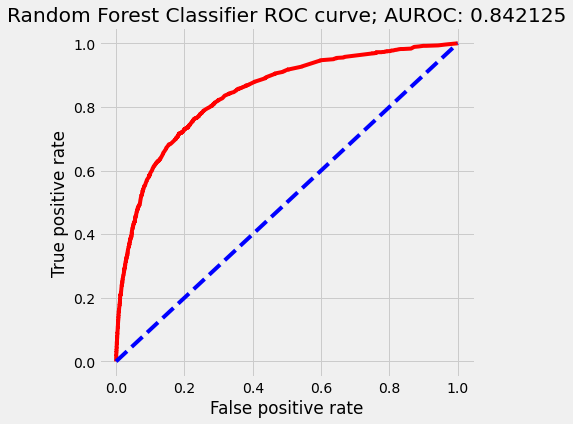

In [31]:
plt.style.use('fivethirtyeight')
prediction = model_rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='r')

plt.plot(fpr, fpr, linestyle = 'dashed', color = 'b')

plt.xlabel('False positive rate')

plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_test, prediction), 6)

plt.title(f'Random Forest Classifier ROC curve; AUROC: {AUROC}');

plt.show()

## GradientBoostingClassifier

In [32]:
categorical_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('one_hot_encoding', OneHotEncoder(handle_unknown = "ignore"))
])

numeric_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

column_transformer=ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric),
    ('categorical', categorical_transformer, categorical)
])

model_gb=Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('classifier', GradientBoostingClassifier(n_estimators=300, learning_rate=.1, max_depth= 5))
])                    
model_gb.fit(X_train, y_train)
print(classification_report(y_test, model_gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     20149
           1       0.51      0.17      0.25      1500

    accuracy                           0.93     21649
   macro avg       0.73      0.58      0.61     21649
weighted avg       0.91      0.93      0.91     21649



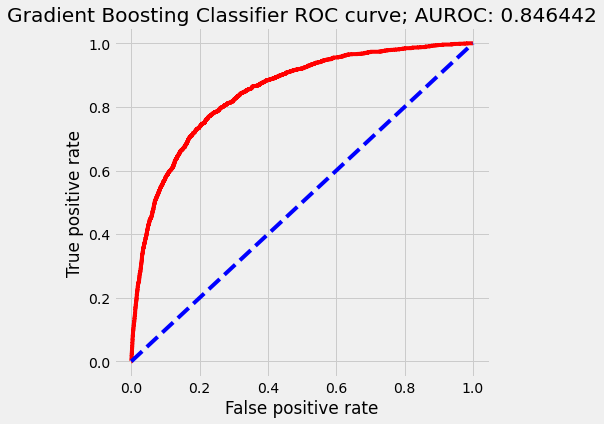

In [33]:
plt.style.use('fivethirtyeight')
prediction = model_gb.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='r')

plt.plot(fpr, fpr, linestyle = 'dashed', color = 'b')

plt.xlabel('False positive rate')

plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_test, prediction), 6)

plt.title(f'Gradient Boosting Classifier ROC curve; AUROC: {AUROC}');

plt.show()

## Voting Classifier 

In [34]:
clf1 = RandomForestClassifier(max_depth=2, random_state=0)

In [35]:
clf2 = XGBClassifier(gamma=5, max_depth=3, min_child_weight=5, subsample=1.0, colsample_bytree=0.8)#using gridsearch best params

In [36]:
clf3 = GradientBoostingClassifier(n_estimators=300, learning_rate=.1, max_depth= 5)

In [37]:
categorical_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('one_hot_encoding', OneHotEncoder(handle_unknown = "ignore"))
])

numeric_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

column_transformer=ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric),
    ('categorical', categorical_transformer, categorical)
])

voting_model=Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('classifier', VotingClassifier(estimators=[('rf', clf1),('xgb', clf2),('gbc', clf3)], voting='soft', weights=[1,2,2]))
])                    
voting_model.fit(X_train, y_train)
print(classification_report(y_test, voting_model.predict(X_test)))

[11:57:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     20149
           1       0.61      0.12      0.20      1500

    accuracy                           0.93     21649
   macro avg       0.78      0.56      0.58     21649
weighted avg       0.92      0.93      0.91     21649



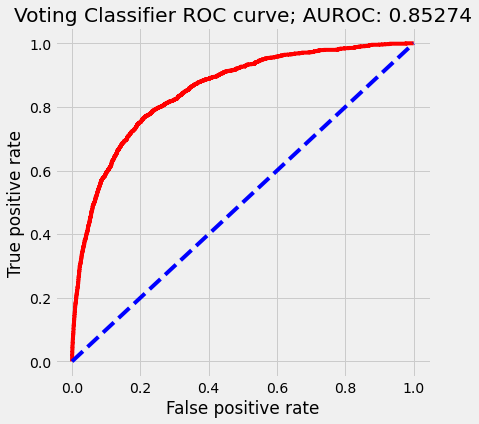

In [38]:
plt.style.use('fivethirtyeight')
prediction = voting_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='r')

plt.plot(fpr, fpr, linestyle = 'dashed', color = 'b')

plt.xlabel('False positive rate')

plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_test, prediction), 6)

plt.title(f'Voting Classifier ROC curve; AUROC: {AUROC}');

plt.show()

## CatBoost Classifier

In [39]:
categorical_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('one_hot_encoding', OneHotEncoder(handle_unknown = "ignore"))
])

numeric_transformer=Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')), 
    ('scaler', MinMaxScaler())
])

column_transformer=ColumnTransformer(transformers=[
    ('numeric', numeric_transformer, numeric),
    ('categorical', categorical_transformer, categorical)
])

model_cat=Pipeline(steps=[
    ('preprocessing', column_transformer),
    ('classifier', CatBoostClassifier(silent=True, iterations=2000, learning_rate=0.01, l2_leaf_reg=3.5, depth=8, rsm=0.98, loss_function='Logloss', eval_metric='AUC',random_seed=42))
])  

model_cat.fit(X_train, y_train)
# print(classification_report(y_test, model_cat.predict(X_test)))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age',
                                                   'number_dependent_family_members',
                                                   'monthly_income',
                                                   'number_of_credit_lines',
                                                   'real_estate_loans',
                                                   'ratio_debt_payment_to_income',
                                                   'credit_line_utilization',
                                        

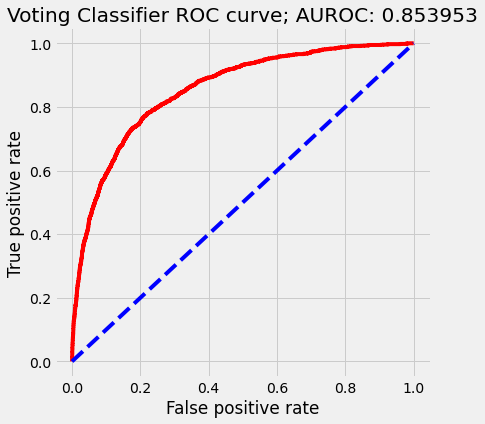

In [40]:
plt.style.use('fivethirtyeight')
prediction = model_cat.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, prediction)
fig, ax = plt.subplots(figsize=(6,6))
plt.plot(fpr, tpr, color='r')

plt.plot(fpr, fpr, linestyle = 'dashed', color = 'b')

plt.xlabel('False positive rate')

plt.ylabel('True positive rate')

AUROC = np.round(roc_auc_score(y_test, prediction), 6)

plt.title(f'Voting Classifier ROC curve; AUROC: {AUROC}');

plt.show()

In [41]:
# model_cat.get_params()

In [42]:
# param_space = {
#         'classifier__iterations': [1000, 1500, 2000],
#         'classifier__depth': [3, 5, 7],
#         'classifier__l2_leaf_reg': [2, 2.5, 3.5],
#         'classifier__learning_rate': [0.01, 0.02, 0.1],
#         'classifier__rsm': [0.9, 0.95]
# }

In [43]:
# gridsearch=GridSearchCV(model_cat,param_space,cv=StratifiedKFold()) 

In [44]:
# gridsearch.fit(X_train, y_train)

In [45]:
# final_model = gridsearch.best_estimator_
# final_model.fit(X_train,y_train)

### Submission Prediction

In [46]:
test = df_test

In [47]:
test

,age,number_dependent_family_members,monthly_income,number_of_credit_lines,real_estate_loans,ratio_debt_payment_to_income,credit_line_utilization,number_of_previous_late_payments_up_to_59_days,number_of_previous_late_payments_up_to_89_days,number_of_previous_late_payments_90_days_or_more,Debt Amount
Id,,,,,,,,,,,
1,30.0,2.0,2200.0,0.0,0.0,0.000000,1.000000,NaN,0.0,0.0,0.000000
2,25.0,2.0,1500.0,3.0,0.0,0.269820,NaN,1.0,1.0,3.0,404.730180
3,48.0,2.0,7163.0,12.0,0.0,0.011865,0.065854,0.0,0.0,0.0,84.988135
4,57.0,0.0,6214.0,6.0,1.0,0.423652,NaN,0.0,0.0,0.0,2632.576349
5,41.0,0.0,1438.0,5.0,0.0,0.282835,0.937578,2.0,0.0,0.0,406.717164
...,...,...,...,...,...,...,...,...,...,...,...
48104,NaN,0.0,2750.0,NaN,NaN,0.865503,0.137762,0.0,0.0,0.0,2380.134496
48105,40.0,3.0,4584.0,7.0,1.0,0.456489,0.438481,0.0,0.0,0.0,2092.543513
48106,58.0,0.0,5100.0,NaN,NaN,0.443442,0.529435,1.0,0.0,0.0,2261.556556


In [48]:
y_pred=model_cat.predict_proba(test)[:,1]
pred=pd.DataFrame(y_pred)
test.reset_index(inplace=True)

In [49]:
dataset=pd.concat([test['Id'], pred], axis=1)
dataset.columns=['Id','Predicted']
dataset.to_csv('CatBoostFinal_Model9.csv',index=False)

### Conclusions

First, I have tried several methods for Outlier Detection, none of them increased my accuracy as replacing outlier values with 'NaN' based on z-score method. Other than that, I introduced new column called Debt Payment, after thinking a bit, I realized given 'monthly_income' and 'Ratio_debt_payment_to_income' columns, we can calculate the total debt payment. Overall, introducing new column, increased my score.

I did run my model several algorithms:

- XGBClassifier()
- RandomForestClassifier()
- GradientBoostingClassifier()
- VotingClassifier()
- CatBoostClassifier()

<i>I commented out the gridsearch parts as they are taking a lot computer power and time to run. I just added the best paramters to the models inside pipeline.

Inside, of the Pipeline, I used Simple Imputation with 'median' strategy and StandardScaler()

I used ROC AUC curve as the evaluation metric along with Classification Report which includes F1 ,Precision, Recall scores.

<font size='4' >Best, result was gained on <font color='red'>CatBoostClassifier() </font>algorithm, after doing hyperparameter tuning with gridsearch. 